In [44]:
! pip3 install -r requirements.txt

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from yellowbrick.regressor import ManualAlphaSelection
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import socket
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

In [46]:
#data import
if socket.gethostname() != 'Rohits-MacBook-Pro.local':
    train = pd.read_csv('C:\\Users\\Mburg\\Documents\\SMU\\Spring 2022\\Quantifying the World\\Case Study 1\\train.csv', low_memory = False)
    materials = pd.read_csv('C:\\Users\\Mburg\\Documents\\SMU\\Spring 2022\\Quantifying the World\\Case Study 1\\unique_m.csv', low_memory = False)
else:
    train = pd.read_csv('~/Documents/QTW_Case_Study_1/superconduct/train.csv')
    materials = pd.read_csv('~/Documents/QTW_Case_Study_1/superconduct/unique_m.csv')


# Business understanding

### Write business understanding here

# Exploring the data (data evaluation/engineering)

We began with two distinct data files. One containing information on the properties of each sample and one containing the chemical formula and composition of each sample. Per our client's direction, each row in one file corresponded to the same row in the other file and these datasets were joined on their respective identical indices. We chose to drop the material name column from the combined dataset as the name of the material is irrelevant to predicting what temperature it will super conduct at. We also dropped the second critical temperature column as it was redundant.

There are 15,542 unique materials represented in the combined dataset with 5,721 materials having identical chemical formulas and chemical makeups. However, the other properties of the material samples vary resulting in 21,263 unique samples. The data are comprised of 168 unique columns representing different attributes of the samples such as atomic mass and elemental composition. The dataset is complete and there are no missing data.

Although not indicated, we assumed that the critical temperatures listed in the dataset were using Kelvin for temperature. Based on the maximum value of 185, this temperature seems too hot for any material to become a superconductor if the temperature scale is in Celsius or Fahrenheit. The mean critical temperature for superconducting is approximately 34.42 Kelvin with a standard deviation of 34.25 degrees. The median critical temperature was 20 Kelvin. The minimum critical temperature seen in the data is 0.000210 Kelvin and the maximum is 185 Kelvin.

The mean number of elements making up each material is approximately 4 with a standard deviation of 1.44 elements. There was a minimum of 1 element and a maximum of 9 elements composing the materials in the dataset. 

In the graphics below, we can see the distribution of the critical temperatures necessary for superconducting. The median, at 20 Kelvin, is indicated by the horizontal line on the box plot. The mean is indicated by the red vertical line on the histogram. 

In [6]:
#column names for train data file
train.columns

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [14]:
#column names for materials data file
materials.columns

Index(['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
       'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
       'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb',
       'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In',
       'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
       'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',
       'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At',
       'Rn', 'critical_temp', 'material'],
      dtype='object')

In [15]:
#check number of unique materials
materials['material'].nunique()

15542

In [16]:
#count duplicates
len(materials)-len(materials.drop_duplicates())

0

In [47]:
#drop redundant critical temp column
#drop material column. material name is irrelevant to predicting temperature for this case study
materials = materials.drop(['critical_temp'], axis = 1)
materials = materials.drop(['material'], axis = 1)

In [48]:
#join materials colunms to train column
train = train.join(materials)

In [49]:
#move the predicted variable critical temp to the first column
#adapted from https://www.geeksforgeeks.org/how-to-move-a-column-to-first-position-in-pandas-dataframe/
first_column = train.pop('critical_temp')

train.insert(0, 'critical_temp', first_column)

In [50]:
#sanity check to make sure data is present and columns are in correct order
train.head()

,critical_temp,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,29.0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,26.0,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,19.0,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,22.0,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,23.0,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [51]:
#check dimensions of dataframe
train.shape

(21263, 168)

In [52]:
#count number of total NaNs in dataframe
train.isna().sum().sum()

0

In [23]:
#summary statistics per column
train.describe()

,critical_temp,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.0,21263.0
mean,34.421219,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,...,0.061558,0.034108,0.020535,0.036663,0.047954,0.042461,0.201009,0.0,0.0,0.0
std,34.254362,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,...,0.864859,0.307888,0.717975,0.205846,0.272298,0.274365,0.655927,0.0,0.0,0.0
min,0.000210,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,5.365000,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,20.000000,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,63.000000,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,185.000000,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,...,45.000000,5.800000,64.000000,8.000000,7.000000,19.000000,14.000000,0.0,0.0,0.0


# Data visualization

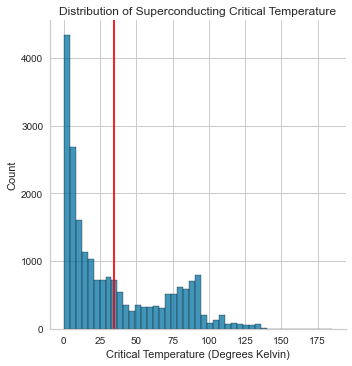

In [43]:
sns.displot(train,
            x='critical_temp')
plt.title('Distribution of Superconducting Critical Temperature')
plt.xlabel('Critical Temperature (Degrees Kelvin)')
plt.ylabel('Count')
plt.axvline(x=train.critical_temp.mean(),
            color='red')

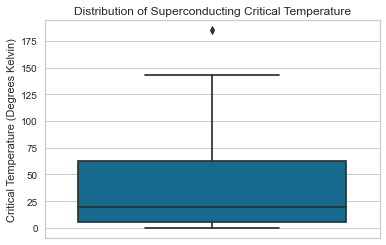

In [25]:
sns.boxplot(y = train['critical_temp'])
plt.title('Distribution of Superconducting Critical Temperature')
plt.ylabel('Critical Temperature (Degrees Kelvin)')
plt.show()

### Correlation

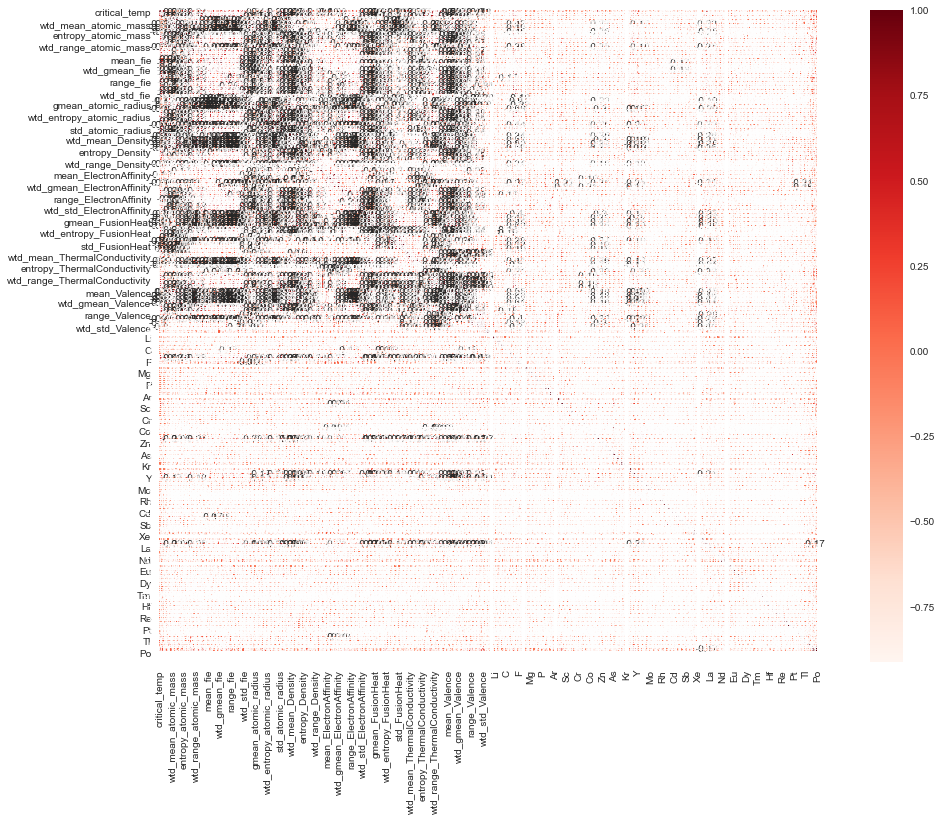

In [72]:
plt.figure(figsize=(15,12))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Model creation

In [54]:
#create the X and y data
X = train.drop(['critical_temp'], axis = 1)
y = train['critical_temp']

In [55]:
minMax = MinMaxScaler()
minMax.fit(X)
transf_X = minMax.transform(X)

In [63]:
std_sc = StandardScaler()
std_sc.fit(X)
transf2_X = std_sc.transform(X)

### Linear

In [56]:
#create scaler, model, and pipeline object
minMax = MinMaxScaler()
linear_mdl = LinearRegression()
pipe_object = Pipeline(steps = [('scale', minMax), ('linear_mdl', linear_mdl)])

In [57]:
pipe_object.fit(X, y)

Pipeline(steps=[('scale', MinMaxScaler()), ('linear_mdl', LinearRegression())])

In [58]:
#print the raw coefficents and the intercept
print(linear_mdl.coef_)
print(linear_mdl.intercept_)

[ 1.16889879e+00  1.70434821e+02 -2.41873543e+02 -8.12115317e+01
  1.41096750e+02 -4.64080118e+01  1.05546200e+01  3.96132017e+01
  2.37587483e+01 -4.87678492e+01  2.27216040e-01 -1.72031643e+02
  3.91021812e+01  1.44071786e+02  3.96307152e+00 -2.59059518e+01
  1.11430566e+02  6.80112992e+01  2.52717024e+01 -5.26737022e+01
 -1.61208154e+01 -1.66546177e+02  5.21844128e+02  9.75732499e+01
 -4.48549884e+02 -3.86530243e+01  3.58214632e+01  1.42135692e+01
 -1.78773152e+01 -2.84712640e+01 -6.04046775e+00 -1.22633407e+02
  1.08696901e+02  1.86482016e+01 -1.00045360e+01 -1.00980106e+01
 -5.13453831e+00 -2.15294135e+01 -1.40969877e+01  3.68508674e+01
 -1.11878656e+01 -1.37099767e+01  1.13296500e+02  3.72093240e+01
 -1.38267784e+02  1.42391246e+01 -3.03823100e+01 -1.17373294e+02
 -1.57414801e+01  1.86029744e+02 -8.13405018e+01  1.33583084e+02
 -1.93988547e+02 -9.02184313e+01  1.38763519e+02 -4.30531115e+01
  4.24949977e+01 -1.67719515e+01  6.52006964e+01 -4.74007314e+01
  4.18811745e+01 -2.51557

In [64]:
std_sc = StandardScaler()
linear_mdl_std = LinearRegression()
pipe_object2 = Pipeline(steps = [('scale', std_sc), ('linear_mdl', linear_mdl_std)])
pipe_object2.fit(X, y)
print(linear_mdl_std.coef_)
print(linear_mdl_std.intercept_)

[ 2.10293778e-01  2.50336793e+01 -3.99900018e+01 -1.23733614e+01
  2.49794029e+01 -8.53680778e+00  2.16360189e+00  1.04047191e+01
  3.11642221e+00 -9.67199334e+00  4.49464314e-02 -1.60521223e+01
  5.76060816e+00  1.20355003e+01  4.98539229e-01 -4.58534330e+00
  1.82574396e+01  1.61416522e+01  4.52273735e+00 -1.15920474e+01
 -4.30384592e+00 -1.34214998e+01  6.01183016e+01  8.62174351e+00
 -6.42987300e+01 -6.77436685e+00  7.66104059e+00  3.73498430e+00
 -2.60670398e+00 -5.64442383e+00 -1.57284379e+00 -1.54548402e+01
  1.55007003e+01  3.05718531e+00 -1.76049269e+00 -1.76894143e+00
 -9.63816767e-01 -3.90492446e+00 -1.50709550e+00  5.75073908e+00
 -1.73204220e+00 -1.17000410e+00  1.12652979e+01  3.32508099e+00
 -1.34807680e+01  2.76595930e+00 -5.18605690e+00 -1.97412283e+01
 -2.06000921e+00  2.48275282e+01 -9.82807283e+00  1.44064446e+01
 -2.64364886e+01 -8.66697598e+00  1.73937103e+01 -7.95545756e+00
  9.00205872e+00 -3.26067506e+00  7.24799202e+00 -7.96035515e+00
  5.90615290e+00 -2.91425

In [59]:
linear_columns = X.iloc[:, linear_mdl.coef_ != 0]

In [60]:
linear_names = list(linear_columns.columns)

In [61]:
linear_coef = list(linear_mdl.coef_)
linear_coef = [x for x in linear_coef if x != 0]

In [62]:
linear_variables = pd.DataFrame()
linear_variables['Column_Name'] = linear_names
linear_variables['Coef_Value'] = linear_coef
linear_variables['Abslt_Coef_Value'] = abs(linear_variables['Coef_Value'])
linear_variables = linear_variables.sort_values(['Abslt_Coef_Value'], ascending = False)
linear_variables.reset_index(drop = True, inplace = True)

In [35]:
linear_variables

,Column_Name,Coef_Value,Abslt_Coef_Value
0,wtd_mean_atomic_radius,5.218441e+02,5.218441e+02
1,wtd_gmean_atomic_radius,-4.485499e+02,4.485499e+02
2,wtd_mean_atomic_mass,-2.418735e+02,2.418735e+02
3,wtd_mean_ThermalConductivity,2.065228e+02,2.065228e+02
4,Ba,1.949629e+02,1.949629e+02
...,...,...,...
158,He,7.823076e-12,7.823076e-12
159,Ar,3.154810e-12,3.154810e-12
160,Ne,2.287948e-12,2.287948e-12
161,Kr,8.526513e-14,8.526513e-14


In [36]:
linear_scores = cross_val_score(linear_mdl, transf_X, y, scoring = 'neg_root_mean_squared_error', cv=5)

In [67]:
avg_linear_scores = (sum(linear_scores)/len(linear_scores))

In [68]:
print('The average RMSE for the linear regression model is: ' + str(abs(avg_linear_scores)))

The average RMSE for the linear regression model is: 24.970298733728747


In [70]:
linear_scores2 = cross_val_score(linear_mdl_std, transf2_X, y, scoring = 'neg_root_mean_squared_error', cv=5)
avg_linear_scores2 = (sum(linear_scores2)/len(linear_scores2))
print(f'The average RMSE for the linear regression model is: {abs(avg_linear_scores2)}')

The average RMSE for the linear regression model is: 24.970298733728583


### There seems to be no difference between Standard scaling vs minmax scaling

### Lasso

TypeError: list indices must be integers or slices, not tuple

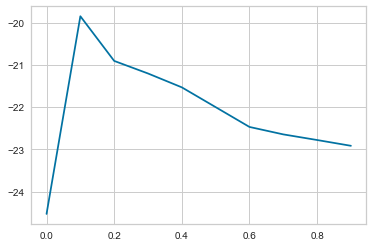

In [39]:
#using yellow bricks to find potential values of Alpha for lasso
#uses negative RMSE, higher value is better
alphas = [x / 10 for x in range(10)]

visualizer = ManualAlphaSelection(
    Lasso(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

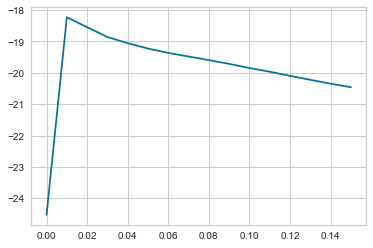

In [33]:
#narrowing in on best alpha
alphas = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

visualizer = ManualAlphaSelection(
    Lasso(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

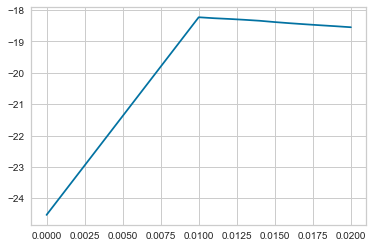

In [40]:
alphas = [0, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02]

visualizer = ManualAlphaSelection(
    Lasso(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

In [35]:
#create scaler, model, and pipeline object
minMax = MinMaxScaler()
lasso_mdl = Lasso(alpha = 0.01)
pipe_object = Pipeline(steps = [('scale', minMax), ('lasso_mdl', lasso_mdl)])

In [36]:
#fit the model on X and y data
pipe_object.fit(X, y)

Pipeline(steps=[('scale', MinMaxScaler()), ('lasso_mdl', Lasso(alpha=0.01))])

In [37]:
#print the raw coefficents and the intercept
print(lasso_mdl.coef_)
print(lasso_mdl.intercept_)

[   0.            6.50313075   -7.69671446    0.           -0.
  -11.69072196   32.68762313   36.44878551   -2.56788149   -0.
  -36.27127004    1.47922229    0.            8.16491514    0.
    0.            4.00136624   24.88898948    0.          -20.14364417
   -4.47740328   -0.           16.34513686  -18.07363137    0.
   -0.            0.           24.01104506   -8.55883245  -32.53829465
   18.16875944   -0.            0.40083011  -17.69176417    4.27375669
  -17.08551382  -19.78186593   -9.43605528    9.39761335   -0.
   -2.0864171    18.48412728    0.            0.          -31.10530272
   -0.          -27.73921481  -38.92565644  -11.70115539   60.90969337
  -12.08496014   -0.            0.           -0.            0.
   -2.04557864   23.88713326   -3.89597127   22.2648786     0.
  -12.32918422    0.          104.36659089  -26.75414932  -60.4181233
    6.50411583   18.22104647   -5.84747144  -35.11225603    0.
   29.82050163   -0.            0.           -0.            0.
    0.  

In [38]:
#create a dataframe of just the selected columns
lasso_columns = X.iloc[:, lasso_mdl.coef_ != 0]

In [39]:
#convert the column names to a list
lasso_names = list(lasso_columns.columns)

In [40]:
#create a list of the coefficent values
lasso_coef = list(lasso_mdl.coef_)
lasso_coef = [x for x in lasso_coef if x != 0]

In [41]:
#create a data frame to hold the selected columns, their coefficent values, and the absolute value of their coefficents
#then display most important coeffecient at the top
lasso_variables = pd.DataFrame()
lasso_variables['Column_Names'] = lasso_names
lasso_variables['Coef_Value'] = lasso_coef
lasso_variables['Abslt_Coef_Value'] = abs(lasso_variables['Coef_Value'])
lasso_variables = lasso_variables.sort_values(['Abslt_Coef_Value'], ascending = False)
lasso_variables.reset_index(drop=True, inplace=True)

In [42]:
lasso_variables

,Column_Names,Coef_Value,Abslt_Coef_Value
0,Ba,174.288687,174.288687
1,Si,-113.612014,113.612014
2,wtd_mean_ThermalConductivity,104.366591,104.366591
3,Bi,77.597746,77.597746
4,std_ElectronAffinity,60.909693,60.909693
...,...,...,...
69,Zr,-1.116198,1.116198
70,Sr,-1.006661,1.006661
71,Ti,-1.003072,1.003072
72,Rb,0.973351,0.973351


In [43]:
lasso_scores = cross_val_score(lasso_mdl, transf_X, y, scoring = 'neg_root_mean_squared_error', cv=5)

In [44]:
avg_lasso_scores = (sum(lasso_scores)/len(lasso_scores))

In [45]:
print('The average RMSE for the Lasso model with 0.01 alpha is: ' + str(abs(avg_lasso_scores))) 

The average RMSE for the Lasso model with 0.01 alpha is: 18.229452949323765


Note: Barium has a very high positive coefficient. Meaning the temperature for super conducting raises by ~174 Kelvin if the sample were to be entirely made of Barium. Negative coefficients lower the temp = better for conductivity. 

The intercept is 7.8972943821622295. If nothing was present in the sample (not realistic) we would expect the sample to be a super conductor at 7.90 K (?).

### Ridge

TypeError: list indices must be integers or slices, not tuple

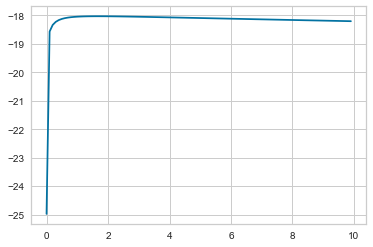

In [46]:
#using yellow bricks to find potential values of Alpha for ridge
#uses negative RMSE, higher value is better
alphas = [x / 10 for x in range(100)]

visualizer = ManualAlphaSelection(
    Ridge(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

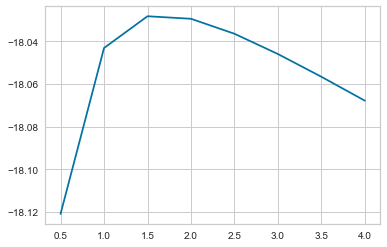

In [47]:
#narrowing in on best alpha
alphas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

visualizer = ManualAlphaSelection(
    Ridge(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

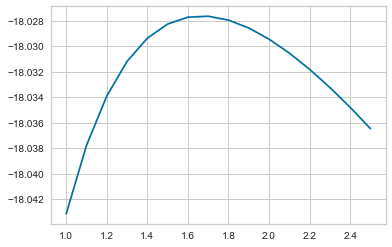

In [48]:
#narrowing in on best alpha
alphas = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]

visualizer = ManualAlphaSelection(
    Ridge(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

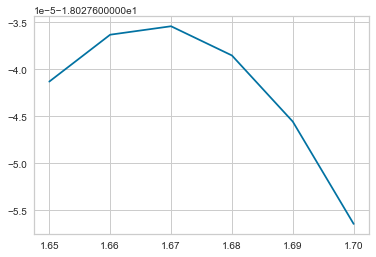

In [49]:
alphas = [1.65, 1.66, 1.67, 1.68, 1.69, 1.70]

visualizer = ManualAlphaSelection(
    Ridge(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

In [50]:
#create scaler, model, and pipeline object
minMax = MinMaxScaler()
ridge_mdl = Ridge(alpha = 1.67)
pipe_object = Pipeline(steps = [('scale', minMax), ('ridge_mdl', ridge_mdl)])

In [51]:
#fit the model on X and y data
pipe_object.fit(X, y)

Pipeline(steps=[('scale', MinMaxScaler()), ('ridge_mdl', Ridge(alpha=1.67))])

In [52]:
print(ridge_mdl.coef_)
print(ridge_mdl.intercept_)

[ 2.73112712e+00  4.24926698e+01 -4.89318481e+01  1.25222699e+01
 -8.65210616e+00 -3.80296399e+01  2.89108644e+01  3.67818163e+01
  8.04247959e+00 -1.03764139e+01 -3.65714314e+01 -3.69184898e+00
  9.55126529e+00  6.07657122e+00  1.02804333e+01  1.19719322e+01
  4.37755749e+01  4.69564056e+01  1.17809414e+01 -3.99042358e+01
 -1.27239036e+01 -8.40870390e-01  5.59991950e+01 -3.66688007e+01
 -5.04202457e+00 -8.21890610e+00  4.39261581e+00  2.54786541e+01
 -1.79073953e+01 -5.63211601e+01  3.85739613e+01 -4.20151979e+01
  2.89670291e+01 -2.44290758e+01  2.04093924e+01 -1.29604185e+01
 -1.87525115e+01 -1.92162583e+01  2.68884856e+00  1.93870662e+01
 -7.75385732e+00  2.56080030e+01  3.42423310e+01 -1.00415826e+00
 -6.58594852e+01  6.16293484e+00 -3.11633354e+01 -7.10833340e+01
 -1.87686847e+01  1.01054884e+02 -3.06733552e+01  1.81924856e+01
 -2.27781751e+01 -6.71952095e-01 -9.77112194e-01 -1.60698221e+01
  3.31558245e+01 -2.23944648e+01  3.45099447e+01  1.20352770e+01
 -8.87107286e+00  5.52053

In [53]:
#create a dataframe of just the selected columns
ridge_columns = X.iloc[:, ridge_mdl.coef_ != 0]

In [54]:
ridge_names = list(ridge_columns.columns)

In [55]:
#create a list of the coefficent values
ridge_coef = list(ridge_mdl.coef_)
ridge_coef = [x for x in ridge_coef if x != 0]

In [56]:
#create a data frame to hold the selected columns, their coefficent values, and the absolute value of their coefficents
#then display most important coeffecient at the top
ridge_variables = pd.DataFrame()
ridge_variables['Column_Names'] = ridge_names
ridge_variables['Coef_Value'] = ridge_coef
ridge_variables['Abslt_Coef_Value'] = abs(ridge_variables['Coef_Value'])
ridge_variables = ridge_variables.sort_values(['Abslt_Coef_Value'], ascending = False)
ridge_variables.reset_index(drop=True, inplace=True)

In [57]:
ridge_variables

,Column_Names,Coef_Value,Abslt_Coef_Value
0,Ba,156.585736,156.585736
1,wtd_mean_ThermalConductivity,113.439259,113.439259
2,Si,-104.198292,104.198292
3,std_ElectronAffinity,101.054884,101.054884
4,Bi,83.266280,83.266280
...,...,...,...
153,O,0.562607,0.562607
154,Ir,-0.233102,0.233102
155,Zr,-0.226257,0.226257
156,V,-0.194803,0.194803


In [58]:
ridge_scores = cross_val_score(ridge_mdl, transf_X, y, scoring = 'neg_root_mean_squared_error', cv=5)

In [59]:
avg_ridge_scores = (sum(ridge_scores)/len(ridge_scores))

In [60]:
print('The average RMSE for the Ridge model with 1.67 alpha is: ' + str(abs(avg_ridge_scores))) 

The average RMSE for the Ridge model with 1.67 alpha is: 18.02763541490335


### Elasticnet

TypeError: list indices must be integers or slices, not tuple

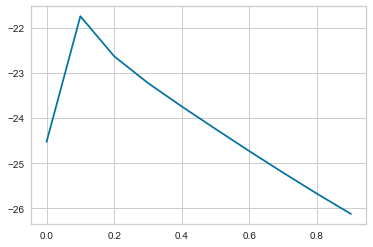

In [61]:
alphas = [x / 10 for x in range(10)]

visualizer = ManualAlphaSelection(
    ElasticNet(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

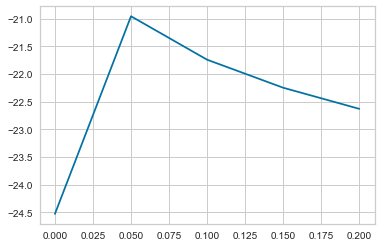

In [62]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2]

visualizer = ManualAlphaSelection(
    ElasticNet(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

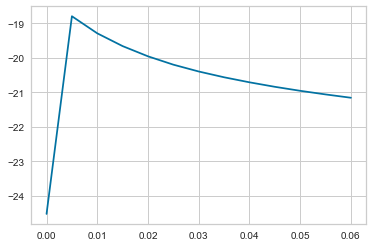

In [63]:
alphas = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.050, 0.055, 0.06]

visualizer = ManualAlphaSelection(
    ElasticNet(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

TypeError: list indices must be integers or slices, not tuple

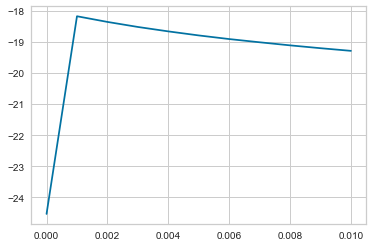

In [64]:
alphas = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010]

visualizer = ManualAlphaSelection(
    ElasticNet(),
    alphas= alphas,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

visualizer.fit(transf_X, y)
visualizer.show()

In [66]:
minMax = MinMaxScaler()
elastic_mdl = ElasticNet(alpha = 0.001)
pipe_object = Pipeline(steps = [('scale', minMax), ('elastic_mdl', elastic_mdl)])

In [67]:
#fit the model on X and y data
pipe_object.fit(X, y)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('elastic_mdl', ElasticNet(alpha=0.001))])

In [68]:
print(elastic_mdl.coef_)
print(elastic_mdl.intercept_)

[ 4.25110818e+00  1.59693687e+01 -1.41054068e+01  8.13397282e+00
 -2.76044050e+00 -1.73296938e+01  2.59816242e+01  3.27772827e+01
 -6.86227253e+00  2.73497689e+00 -3.31850942e+01  1.14479757e+01
  5.02417664e-01  1.34543227e+01  1.34089852e+00  3.07861661e-01
  1.14123438e+01  2.76947179e+01  3.01841913e+00 -1.75282191e+01
 -1.48461575e+01 -6.04591690e+00  2.78401463e+01 -1.48242297e+01
  9.53087835e+00 -6.56541719e-01  1.21407800e+01  2.65735920e+01
 -1.29782703e+01 -2.82564386e+01  2.27937915e+01 -1.59475110e+01
  4.23718966e+00 -1.84789698e+01  5.48956110e+00 -9.53112346e+00
 -2.08003513e+01 -8.05425576e+00  1.59434286e+01  3.78536686e+00
 -1.14409982e+01  1.76924092e+01  4.27153054e+00  9.95362192e-01
 -3.34905409e+01 -8.73213716e+00 -3.03979633e+01 -2.60679061e+01
 -1.78746012e+01  3.31606933e+01 -2.80072560e+00  4.59036877e+00
 -0.00000000e+00 -5.24954690e+00 -9.81234865e-02 -5.82116609e+00
  2.41202214e+01 -1.09070297e+01  1.55954542e+01  4.82767624e+00
 -1.23107071e+01  8.06536

In [69]:
elastic_columns = X.iloc[:, elastic_mdl.coef_ != 0]

In [70]:
elastic_names = list(elastic_columns.columns)

In [71]:
elastic_coef = list(elastic_mdl.coef_)
elastic_coef = [x for x in elastic_coef if x != 0]

In [72]:
elastic_variables = pd.DataFrame()
elastic_variables['Column_Names'] = elastic_names
elastic_variables['Coef_Value'] = elastic_coef
elastic_variables['Abslt_Coef_Value'] = abs(elastic_variables['Coef_Value'])
elastic_variables = elastic_variables.sort_values(['Abslt_Coef_Value'], ascending = False)
elastic_variables.reset_index(drop=True, inplace=True)

In [73]:
elastic_variables

,Column_Names,Coef_Value,Abslt_Coef_Value
0,Ba,89.459940,89.459940
1,Bi,57.973166,57.973166
2,wtd_mean_ThermalConductivity,49.121027,49.121027
3,wtd_std_ThermalConductivity,45.618616,45.618616
4,wtd_std_Valence,-42.491786,42.491786
...,...,...,...
144,Cs,-0.315125,0.315125
145,entropy_fie,0.307862,0.307862
146,wtd_gmean_FusionHeat,-0.098123,0.098123
147,Pb,-0.052568,0.052568


In [74]:
elastic_scores = cross_val_score(elastic_mdl, transf_X, y, scoring = 'neg_root_mean_squared_error', cv=5)

In [75]:
avg_elastic_scores = (sum(elastic_scores)/len(elastic_scores))

In [76]:
print('The average RMSE for the Elastic Net model with 0.001 alpha is: ' + str(abs(avg_elastic_scores)))

The average RMSE for the Elastic Net model with 0.001 alpha is: 18.17773337774483


# Model Comparison

In [77]:
linear_variables.head(10)

,Column_Name,Coef_Value,Abslt_Coef_Value
0,wtd_mean_atomic_radius,521.844128,521.844128
1,wtd_gmean_atomic_radius,-448.549884,448.549884
2,wtd_mean_atomic_mass,-241.873543,241.873543
3,wtd_mean_ThermalConductivity,206.522848,206.522848
4,Ba,194.962948,194.962948
5,wtd_mean_FusionHeat,-193.988547,193.988547
6,std_ElectronAffinity,186.029744,186.029744
7,mean_fie,-172.031643,172.031643
8,mean_atomic_mass,170.434821,170.434821
9,mean_atomic_radius,-166.546177,166.546177


In [78]:
lasso_variables.head(10)

,Column_Names,Coef_Value,Abslt_Coef_Value
0,Ba,174.288687,174.288687
1,Si,-113.612014,113.612014
2,wtd_mean_ThermalConductivity,104.366591,104.366591
3,Bi,77.597746,77.597746
4,std_ElectronAffinity,60.909693,60.909693
5,wtd_gmean_ThermalConductivity,-60.418123,60.418123
6,Hg,48.714436,48.714436
7,wtd_std_Valence,-39.336539,39.336539
8,range_ElectronAffinity,-38.925656,38.925656
9,Ag,-38.403420,38.403420


In [79]:
ridge_variables.head(10)

,Column_Names,Coef_Value,Abslt_Coef_Value
0,Ba,156.585736,156.585736
1,wtd_mean_ThermalConductivity,113.439259,113.439259
2,Si,-104.198292,104.198292
3,std_ElectronAffinity,101.054884,101.054884
4,Bi,83.266280,83.266280
5,range_ElectronAffinity,-71.083334,71.083334
6,wtd_gmean_ElectronAffinity,-65.859485,65.859485
7,Ag,-60.407004,60.407004
8,wtd_gmean_ThermalConductivity,-57.620197,57.620197
9,std_atomic_radius,-56.321160,56.321160


In [80]:
elastic_variables.head(10)

,Column_Names,Coef_Value,Abslt_Coef_Value
0,Ba,89.459940,89.459940
1,Bi,57.973166,57.973166
2,wtd_mean_ThermalConductivity,49.121027,49.121027
3,wtd_std_ThermalConductivity,45.618616,45.618616
4,wtd_std_Valence,-42.491786,42.491786
5,Si,-40.534365,40.534365
6,wtd_gmean_ElectronAffinity,-33.490541,33.490541
7,wtd_std_atomic_mass,-33.185094,33.185094
8,std_ElectronAffinity,33.160693,33.160693
9,range_atomic_mass,32.777283,32.777283


In [93]:
print('The intercept for the Linear Model is: ' + str(linear_mdl.intercept_) + '\nThe average RMSE for the Linear model is: ' + str(abs(avg_linear_scores)) + '\nThe Linear model used ' + str(len(linear_variables)) + ' predictors')
print('----------------------------------------')
print('The alpha for the Lasso Model was 0.010' + '\nThe intercept for the Lasso Model is: ' + str(lasso_mdl.intercept_) + '\nThe average RMSE of the Lasso model is: ' + str(abs(avg_lasso_scores)) + '\nThe Lasso model used ' + str(len(lasso_variables)) + ' predictors')
print('----------------------------------------')
print('The alpha for the Ridge Model was 1.670' + '\nThe intercept for the Ridge Model is: ' + str(ridge_mdl.intercept_) + '\nThe average RMSE of the Ridge model is: ' + str(abs(avg_ridge_scores)) + '\nThe Ridge model used ' + str(len(ridge_variables)) + ' predictors')
print('----------------------------------------')
print('The alpha for the Elastic Net Model was 0.001' + '\nThe intercept for the Elastic Net Model is: ' + str(elastic_mdl.intercept_) + '\nThe average RMSE of the Elastic Net model is: ' + str(abs(avg_elastic_scores)) + '\nThe Elastic model used ' + str(len(elastic_variables)) + ' predictors')

The intercept for the Linear Model is: 0.6314330445692633
The average RMSE for the Linear model is: 24.970298733728743
The Linear model used 164 predictors
----------------------------------------
The alpha for the Lasso Model was 0.010
The intercept for the Lasso Model is: 7.8972943821622295
The average RMSE of the Lasso model is: 18.229452949323765
The Lasso model used 74 predictors
----------------------------------------
The alpha for the Ridge Model was 1.670
The intercept for the Ridge Model is: -3.6227510109969643
The average RMSE of the Ridge model is: 18.02763541490335
The Ridge model used 158 predictors
----------------------------------------
The alpha for the Elastic Net Model was 0.001
The intercept for the Elastic Net Model is: -6.646947602606943
The average RMSE of the Elastic Net model is: 18.17773337774483
The Elastic model used 149 predictors


The original Linear Model achieved an RMSE of 24.97 K. Lasso had an average RMSE of 18.23. Ridge was 18.03. Elastic Net was 18.18. Despite the highly different alphas among the 3 models they almost perfectly agree on the amount of error and each has better performance than the original linear model. However, Lasso accomplishes this with only 73 predictors, as opposed to the 157 in the ridge model and the 148 in the Elastic model. The top 10 predictors are very similar in the Lasso and Ridge models although the importance and coefficients do vary. There are some differences in the top predictors when looking at the Linear or Elastic Net model. As we would expect, Silicon, Mercury, and Silver are all very good conductors as indicated by their large negative coefficients compared to the Barium and Bismuth which are not and have very large positive coefficients. There is a large importance placed on thermal conductivity, valence, and electron affinity as well. The RMSE is equivalent to an error of approx plus/minus 64.5 degrees Fahrenheit. 

** I would make the argument that tuned lasso had the best performance. 18.22 at 74 predictors vs 18.03 with 158 predictors. 

### Using Recursive Feature elimitation

In [77]:
selector = RFECV(linear_mdl, step=1, cv=5)

In [78]:
selector = selector.fit(transf_X, y)

In [79]:
selector.support_

array([False,  True,  True,  True,  True,  True, False,  True, False,
        True, False,  True,  True, False, False, False,  True,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
       False, False, False, False,  True, False, False,  True,  True,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,

In [85]:
rfe_v = pd.DataFrame()
rfe_v['Column_Name'] = list(X.columns)
rfe_v['Is_important'] = list(selector.support_)
rfe_v['Rank'] = list(selector.ranking_) 

In [88]:
rfe_v.sort_values(by=['Rank'], inplace=True)

In [109]:
rfe_v[rfe_v['Is_important'] == True ]

,Column_Name,Is_important,Rank
59,std_FusionHeat,True,1
62,wtd_mean_ThermalConductivity,True,1
61,mean_ThermalConductivity,True,1
60,wtd_std_FusionHeat,True,1
58,wtd_range_FusionHeat,True,1
...,...,...,...
106,Fe,True,1
31,mean_Density,True,1
32,wtd_mean_Density,True,1
100,Ca,True,1


In [110]:
rfe_columns = rfe_v[rfe_v['Is_important'] == True ]['Column_Name']

In [102]:
X_RFE = X[rfe_columns]
std_sc = StandardScaler()
X_RFE_scaled =  std_sc.fit_transform(X_RFE)
linear_RFE_std = LinearRegression()

linear_RFE_std.fit(X_RFE_scaled, y)

LinearRegression()

In [103]:
RFE_scores = cross_val_score(linear_RFE_std, X_RFE_scaled, y, scoring = 'neg_root_mean_squared_error', cv=5)

In [104]:
RFE_scores

array([-22.35546269, -21.51387912, -15.76380223, -12.07928054,
       -15.86978633])

In [98]:
print(f' Reverse Feature selection RSE is{sum(RSE_scores)/len(RSE_scores)}')

-17.516442181093907

In [111]:
print(f'The intercept for the Reverse Feature selection Linear Model is: {linear_RFE_std.intercept_} \nThe average RMSE for the Reverse Feature selection Linear model is: {abs(sum(RSE_scores)/len(RSE_scores))} \nThe Linear model used {len(rfe_columns)} predictors')

The intercept for the Reverse Feature selection Linear Model is: 34.421219135352494 
The average RMSE for the Reverse Feature selection Linear model is: 17.516442181093907 
The Linear model used 66 predictors
